In [1]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from optic.models import phaseNoise, linFiberCh, KramersKronigRx, photodiode

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const
from tqdm.notebook import tqdm

from tensorflow.keras.layers import Dense, BatchNormalization, Conv1DTranspose, Conv1D, Flatten, Add
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K

In [14]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
#paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 100       # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
FO = paramTx.Rs/2 + 1e9  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate
Ts = 1 / Fs

# photodiode parameters
paramPD = parameters()
paramPD.B  = 1.1*paramTx.Rs
paramPD.Fs = Fs

In [15]:
Rolloff = np.arange(0.05, 0.95, 0.05)

BER_KK = np.zeros(Rolloff.size)
SER_KK = np.zeros(Rolloff.size) 
GMI_KK = np.zeros(Rolloff.size)
MI_KK  = np.zeros(Rolloff.size)
SNR_KK = np.zeros(Rolloff.size)

for indRolloff, Rolloff_ in enumerate(Rolloff):

    paramTx.alphaRRC = Rolloff_
    # generate optical signal signal
    sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # simulate linear signal propagation
    sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

    # receiver detection and demodulation
    Fc = paramTx.Fc
    Ts = 1 / Fs
    mod = QAMModem(m=paramTx.M)

    freqGrid = paramTx.freqGrid
    print(
        "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
        % (
            chIndex,
            (Fc + freqGrid[chIndex]) / 1e12,
            const.c / (Fc + freqGrid[chIndex]) / 1e-9,
        )
    )

    symbTx = symbTx_[:, :, chIndex]

    Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

    print(
        "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
        % (Plo_dBm, lw / 1e3, FO / 1e6)
    )

    # generate LO field
    π = np.pi
    t = np.arange(0, len(sigCh))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

    sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

    # Add LO to the received signal
    sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
    sfm = sigRx.copy()

    print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

    # ### Phase-retrieval stage

    # In[4]:
    
    # simulate ideal direct-detection optical receiver
    Ipd = photodiode(sigRx, paramPD)
    Amp = np.sqrt(Ipd)
    Amp = resample(Amp, paramADC)

    # resampling to ADC sampling rate
    sigCh = resample(sigCh, paramADC)
    sfm = resample(sfm, paramADC)
    newFs = paramADC.SpS_out*paramTx.Rs

    sfm = sfm/np.sqrt(signal_power(sfm))
    
    # Kramers-Kronig phase-retrieval
    phiTime = KramersKronigRx(Amp, newFs)

    # optical field reconstruction
    sigRx = Amp*np.exp(1j*phiTime)

    # remove DC level
    sigRx -= np.sqrt(Plo)  # np.mean(sigRx)

    # downshift to baseband
    t = np.arange(0, len(sigRx))*(1/newFs)
    sigRx *= np.exp(-1j * (2 * π * FO * t))

    # correct for (possible) phase ambiguity
    rot = np.mean(sigCh/sigRx)
    sigRx = rot * sigRx
    sigRx = sigRx / np.sqrt(signal_power(sigRx))

    # #### Standard receiver processing

    # In[5]:

    # resample to 2 samples/symbol:
    paramRes = parameters()
    paramRes.Rs = paramTx.Rs
    paramRes.SpS_in = paramADC.SpS_out
    paramRes.SpS_out = 2

    sigRx = resample(sigRx, paramRes)

    # Matched filtering and CD compensation

    # Matched filtering
    if paramTx.pulse == "nrz":
        pulse = pulseShape("nrz", paramADC.SpS_out)
    elif paramTx.pulse == "rrc":
        pulse = pulseShape(
            "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
        )

    pulse = pulse / np.max(np.abs(pulse))
    sigRx = firFilter(pulse, sigRx)

    # plot constellations after matched filtering
    #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

    # CD compensation
    sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

    #plot constellations after CD compensation
    #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

    # Downsampling to 2 sps and re-synchronization with transmitted sequences
    sigRx = sigRx.reshape(-1, 1)

    symbRx = symbolSync(sigRx, symbTx, 2)

    # In[6]:

    # Power normalization
    x = sigRx
    d = symbRx

    x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
    d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

    # Adaptive equalization
    mod = QAMModem(m=paramTx.M)

    paramEq = parameters()
    paramEq.nTaps = 15
    paramEq.SpS = 2
    paramEq.mu = [5e-3, 2e-3]
    paramEq.numIter = 5
    paramEq.storeCoeff = False
    paramEq.alg = ["nlms", "dd-lms"]
    paramEq.M = paramTx.M
    paramEq.L = [20000, 80000]

    y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

    discard = int(paramEq.L[0]/2)

    #plot constellations after adaptive equalization
    #pconst(y_EQ[discard:-discard, :], lim=True)

    # In[7]:

    # Carrier phase recovery
    paramCPR = parameters()
    paramCPR.alg = "bps"
    paramCPR.M = paramTx.M
    paramCPR.N = 75
    paramCPR.B = 64
    paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

    y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

    y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

    discard = 5000

    # plot constellations after CPR
    #pconst(y_CPR[discard:-discard, :], lim=True)

    # #### Evaluate transmission metrics

    # In[8]:

    # correct for (possible) phase ambiguity
    for k in range(y_CPR.shape[1]):
        rot = np.mean(d[:, k] / y_CPR[:, k])
        y_CPR[:, k] = rot * y_CPR[:, k]

    y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

    ind = np.arange(discard, d.shape[0] - discard)
    BER_KK[indRolloff], SER_KK[indRolloff], SNR_KK[indRolloff] = fastBERcalc(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
    GMI_KK[indRolloff], _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
    MI_KK[indRolloff] = monteCarloMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')

    print("Results:\n")
    print("SER: %.2e" % (SER_KK[indRolloff]))
    print("BER: %.2e" % (BER_KK[indRolloff]))
    print("SNR: %.2f dB" % (SNR_KK[indRolloff]))
    print("MI: %.2f bits" % (MI_KK[indRolloff]))
    print("GMI: %.2f bits" % (GMI_KK[indRolloff]))

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 29.76 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 4.44e-05
BER: 1.39e-05
SNR: 29.07 dB
MI: 3.99 bits
GMI: 3.99 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 25.15 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 2.22e-05
BER: 5.56e-06
SNR: 23.91 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 22.63 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 21.57 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 3.33e-05
BER: 8.33e-06
SNR: 20.64 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 1.56e-04
BER: 3.89e-05
SNR: 19.79 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 5.33e-04
BER: 1.33e-04
SNR: 18.99 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 7.11e-04
BER: 1.78e-04
SNR: 18.42 dB
MI: 4.00 bits
GMI: 4.00 bits


In [16]:
Rolloff = np.arange(0.05, 0.95, 0.05)

BER_NN = np.zeros(Rolloff.size)
SER_NN = np.zeros(Rolloff.size)
GMI_NN = np.zeros(Rolloff.size)
MI_NN  = np.zeros(Rolloff.size)
SNR_NN = np.zeros(Rolloff.size)

N = 72  # number of input amplitude samples to the NN

for indNN, Rolloff_NN in enumerate(Rolloff):

    paramTx.alphaRRC = Rolloff_NN
    model = tf.keras.models.load_model('ConvNets_models/test_ConvNet_model_SpS_'+str(paramADC.SpS_out)+'_FO_'+str(FO/10e9)+'GHz_Rolloff_'+str(round(paramTx.alphaRRC, 2)))

    # generate optical signal signal
    sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # simulate linear signal propagation
    sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

    # receiver detection and demodulation
    Fc = paramTx.Fc
    Ts = 1 / Fs
    mod = QAMModem(m=paramTx.M)

    freqGrid = paramTx.freqGrid
    print(
        "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
        % (
            chIndex,
            (Fc + freqGrid[chIndex]) / 1e12,
            const.c / (Fc + freqGrid[chIndex]) / 1e-9,
        )
    )

    symbTx = symbTx_[:, :, chIndex]

    Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

    print(
        "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
        % (Plo_dBm, lw / 1e3, FO / 1e6)
    )

    # generate LO field
    π = np.pi
    t = np.arange(0, len(sigCh))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

    sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

    # Add LO to the received signal
    sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
    sfm = sigRx.copy()

    print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

    # ### Phase-retrieval stage

    # In[4]:
    
    # simulate ideal direct-detection optical receiver
    Ipd = photodiode(sigRx, paramPD)
    Amp = np.sqrt(Ipd)
    Amp = resample(Amp, paramADC)

    # resampling to ADC sampling rate
    sigCh = resample(sigCh, paramADC)
    sfm = resample(sfm, paramADC)
    newFs = paramADC.SpS_out*paramTx.Rs

    sfm = sfm/np.sqrt(signal_power(sfm))
    
    sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
    sigAmp   = np.pad(np.abs(sfm), (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

    # create set of input features
    X_input = np.zeros((len(sigPhase), N)) #(L,N)

    for indPhase in range(len(sigPhase)):
        X_input[indPhase] = sigAmp[indPhase:N+indPhase]

    sigRx_NN = model.predict(X_input)

    # optical field reconstruction
    sigRx = sigRx_NN[:,0]+1j*sigRx_NN[:,1]

    # remove DC level
    sigRx -= np.sqrt(Plo) # np.sqrt(Plo) 

    # downshift to baseband
    t = np.arange(0, len(sigRx))*(1/newFs)
    sigRx *= np.exp(-1j * (2 * π * FO * t))

    # correct for (possible) phase ambiguity
    rot = np.mean(sigCh/sigRx)
    sigRx = rot * sigRx
    sigRx = sigRx / np.sqrt(signal_power(sigRx))

    # #### Standard receiver processing

    # In[5]:

    # resample to 2 samples/symbol:
    paramRes = parameters()
    paramRes.Rs = paramTx.Rs
    paramRes.SpS_in = paramADC.SpS_out
    paramRes.SpS_out = 2

    sigRx = resample(sigRx, paramRes)

    # Matched filtering and CD compensation

    # Matched filtering
    if paramTx.pulse == "nrz":
        pulse = pulseShape("nrz", paramADC.SpS_out)
    elif paramTx.pulse == "rrc":
        pulse = pulseShape(
            "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
        )

    pulse = pulse / np.max(np.abs(pulse))
    sigRx = firFilter(pulse, sigRx)

    # plot constellations after matched filtering
    #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

    # CD compensation
    sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

    #plot constellations after CD compensation
    #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

    # Downsampling to 2 sps and re-synchronization with transmitted sequences
    sigRx = sigRx.reshape(-1, 1)

    symbRx = symbolSync(sigRx, symbTx, 2)

    # In[6]:

    # Power normalization
    x = sigRx
    d = symbRx

    x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
    d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

    # Adaptive equalization
    mod = QAMModem(m=paramTx.M)

    paramEq = parameters()
    paramEq.nTaps = 15
    paramEq.SpS = 2
    paramEq.mu = [5e-3, 2e-3]
    paramEq.numIter = 5
    paramEq.storeCoeff = False
    paramEq.alg = ["nlms", "dd-lms"]
    paramEq.M = paramTx.M
    paramEq.L = [20000, 80000]

    y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

    discard = int(paramEq.L[0]/2)

    #plot constellations after adaptive equalization
    #pconst(y_EQ[discard:-discard, :], lim=True)

    # In[7]:

    # Carrier phase recovery
    paramCPR = parameters()
    paramCPR.alg = "bps"
    paramCPR.M = paramTx.M
    paramCPR.N = 75
    paramCPR.B = 64
    paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

    y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

    y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

    discard = 5000

    # plot constellations after CPR
    #pconst(y_CPR[discard:-discard, :], lim=True)

    # #### Evaluate transmission metrics

    # In[8]:

    # correct for (possible) phase ambiguity
    for k in range(y_CPR.shape[1]):
        rot = np.mean(d[:, k] / y_CPR[:, k])
        y_CPR[:, k] = rot * y_CPR[:, k]

    y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

    ind = np.arange(discard, d.shape[0] - discard)
    BER_NN[indNN], SER_NN[indNN], SNR_NN[indNN] = fastBERcalc(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
    GMI_NN[indNN], _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
    MI_NN[indNN] = monteCarloMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')

    print("Results:\n")
    print("SER: %.2e" % (SER_NN[indNN]))
    print("BER: %.2e" % (BER_NN[indNN]))
    print("SNR: %.2f dB" % (SNR_NN[indNN]))
    print("MI: %.2f bits" % (MI_NN[indNN]))
    print("GMI: %.2f bits" % (GMI_NN[indNN]))

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 49s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 31.30 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 48s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 22.83 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 48s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 23.84 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 53s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 23.00 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 48s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 1.11e-05
BER: 2.78e-06
SNR: 20.95 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 48s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 6.67e-05
BER: 1.67e-05
SNR: 19.81 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 49s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 1.00e-04
BER: 2.50e-05
SNR: 19.26 dB
MI: 4.00 bits
GMI: 4.00 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 47s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 1.60e-03
BER: 4.00e-04
SNR: 17.65 dB
MI: 3.99 bits
GMI: 3.99 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 46s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 1.48e-03
BER: 3.69e-04
SNR: 17.81 dB
MI: 3.99 bits
GMI: 3.99 bits


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 51s 4ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

Results:

SER: 3.13e-03
BER: 7.83e-04
SNR: 17.36 dB
MI: 3.99 bits
GMI: 3.99 bits


C:\Users\optic\AppData\Local\Temp\ipykernel_32\796388795.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(Rolloff, np.log10(BER_NN), '-o', label='Rede Neural')
C:\Users\optic\AppData\Local\Temp\ipykernel_32\796388795.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(Rolloff, np.log10(BER_KK), '-x', label='Algoritmo de KK')
C:\Users\optic\AppData\Local\Temp\ipykernel_32\796388795.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(Rolloff, np.log10(SER_NN), '-o', label='Rede Neural')
C:\Users\optic\AppData\Local\Temp\ipykernel_32\796388795.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(Rolloff, np.log10(SER_KK), '-x', label='Algoritmo de KK')


Text(0.5, 1.0, 'SER vs Rolloff')

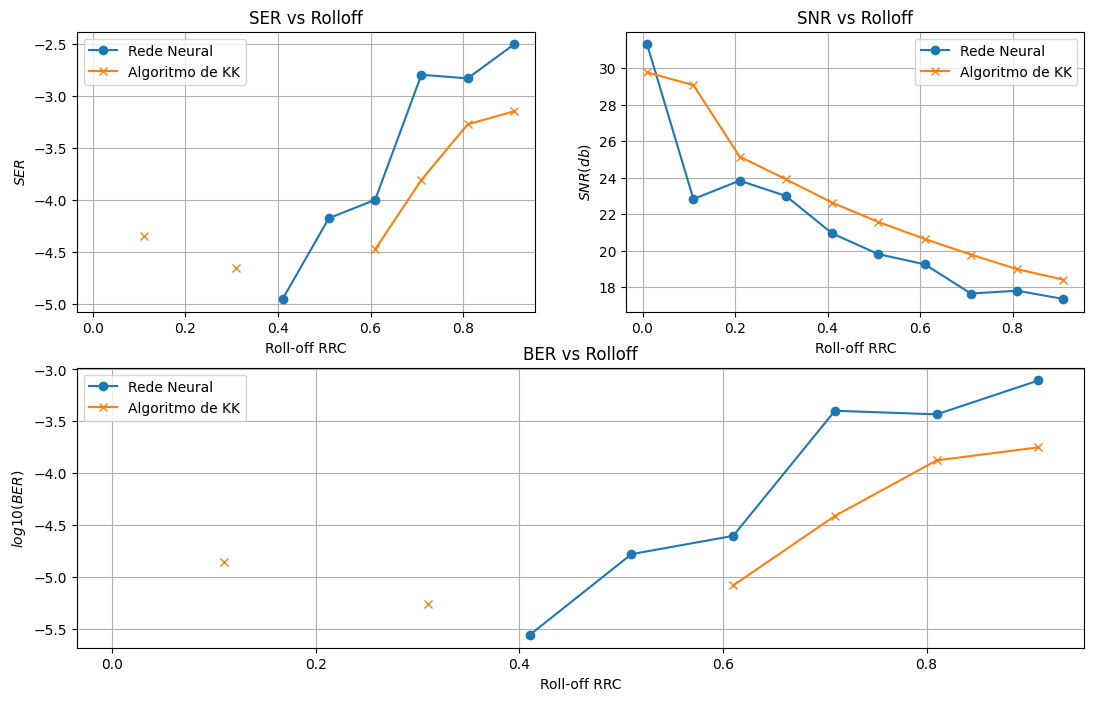

In [25]:
plt.figure(num=None, figsize=(13, 8))

grafico1 = plt.subplot(2, 1, 2)
plt.plot(Rolloff, np.log10(BER_NN), '-o', label='Rede Neural')
plt.plot(Rolloff, np.log10(BER_KK), '-x', label='Algoritmo de KK')
plt.xlabel('Roll-off RRC')
plt.ylabel('$log10(BER)$')
plt.grid()
plt.legend()
plt.title('BER vs Rolloff')

grafico2 = plt.subplot(2, 2, 2, sharex=grafico1)
plt.plot(Rolloff, SNR_NN, '-o', label='Rede Neural')
plt.plot(Rolloff, SNR_KK, '-x', label='Algoritmo de KK')
plt.xlabel('Roll-off RRC')
plt.ylabel('$SNR(db)$')
plt.grid()
plt.legend()
plt.title('SNR vs Rolloff')

grafico3 = plt.subplot(2, 2, 1, sharex=grafico2)
plt.plot(Rolloff, np.log10(SER_NN), '-o', label='Rede Neural')
plt.plot(Rolloff, np.log10(SER_KK), '-x', label='Algoritmo de KK')
plt.xlabel('Roll-off RRC')
plt.ylabel('$SER$')
plt.grid()
plt.legend()
plt.title('SER vs Rolloff')
